<a href="https://colab.research.google.com/github/mango766/ml_learning/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Models with MNIST


This notebook is based on the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Jonathan Ho, Ajay Jain and Pieter Abbeel. The code is based on the [Course](https://dataflowr.github.io/website/modules/18a-diffusion/). The porpuse of this notebook is to understand the basic idea of the paper. 

## Import libraries


Since the code will be basic and simple, we will use the basic libraries. We will use the `torch` library for the neural network and `torchvision` for the dataset.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from IPython.display import Image
import math

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Algorithm

Before we start, let's understand the algorithm. The algorithm is based on the diffusion process. The diffusion process is a stochastic process that describes the movement of a particle in a medium. The particle moves in a random direction and the speed of the particle is proportional to the concentration of the medium. The diffusion process is used in many fields like physics, chemistry, biology, etc. The diffusion process is a key component of DDPM and refers to a sequence of conditional distributions that are used to gradually add noise to the input data. The process involves adding increasing levels of noise to the data, with the noise at each level being a function of the noise at the previous level. In each step of the process, the noise is added to the data, and the model learns to denoise the corrupted sample to recover the original data.

More specifically, in each step of the diffusion process, the model is given a noisy sample and is asked to predict the corresponding denoised sample. The noise at each step is typically drawn from a Gaussian distribution with zero mean and a standard deviation that increases over time, with the noise at the final step being the largest. By running the diffusion process in reverse (i.e., by denoising the noise at each step), the model can generate new samples that are similar to the ones in the original dataset.


In [ ]:
Image(url="https://hojonathanho.github.io/diffusion/assets/img/pgm_diagram_xarrow.png")

The diffusion process is connected to DDPM in that the model is trained to maximize the likelihood of the data given the diffusion process and the model parameters. The likelihood function is defined as the product of the conditional distributions that describe the diffusion process. By maximizing the likelihood function, the model learns to denoise the corrupted samples in a way that captures the complexity and structure of the data distribution.

### Plotting function
Let's define a function to plot the images. We will use this function to plot the images in the dataset and the generated images. We will use the `matplotlib` library to plot the images. 

In [ ]:
def show_images(images, title=""):
    # Get number of images
    num_images = len(images)

    # Determine number of rows and columns needed for the subplots
    num_rows = int(math.sqrt(num_images))
    num_cols = math.ceil(num_images / num_rows)

    # Create figure and add subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    fig.suptitle(title, fontsize=30)

    # Display each image in its corresponding subplot
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
            ax.axis("off")

    # Show the figure
    plt.show()

Let's define device to use GPU if available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Sinusoidal embedding
The paper uses sinusoidal embedding to embed the images. The embedding is used to add the positional information to the images. Will be used in Unet later. The embedding is known from paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762). 

In paper they define the embedding as:

$$
\begin{aligned}
P E_{(p o s, 2 i)} & =\sin \left(p o s / 10000^{2 i / d_{\mathrm{model}}}\right) \\
P E_{(p o s, 2 i+1)} & =\cos \left(p o s / 10000^{2 i / d_{\mathrm{model}}}\right)
\end{aligned}
$$

where $pos$ is the position and $i$ is the dimension. $d_{\mathrm{model}}$ is the size word embedding.

In [ ]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    positions = torch.arange(n).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) * -(math.log(10000.0) / d))
    embeddings = torch.zeros(n, d)

    # Compute the sinusoidal embeddings
    embeddings[:, 0::2] = torch.sin(positions * div_term)
    embeddings[:, 1::2] = torch.cos(positions * div_term)

    return embeddings

In [ ]:
class ConvNet(nn.Module):
    def __init__(
        self,
        input_shape,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super(ConvNet, self).__init__()
        self.layer_norm = nn.LayerNorm(input_shape)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv(out)
        out = self.activation(out)
        return out


def convolution_block(image_size, in_channels, out_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
    )


def tiny_upsampling_block(image_size, in_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, in_channels // 2),
        ConvNet((in_channels // 2, image_size, image_size), in_channels // 2, in_channels // 4),
        ConvNet((in_channels // 4, image_size, image_size), in_channels // 4, in_channels // 4),
    )


In [ ]:
class TinyUNet(nn.Module):

    def _make_time_embedding_layer(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.SiLU(),
            nn.Linear(output_dim, output_dim)
        )

    def __init__(self, input_channels=1, output_channels=1, size=32, num_steps=1000, time_emb_dim=100):
        super(TinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embedding = nn.Embedding(num_steps, time_emb_dim)
        self.time_embedding.weight.data = sinusoidal_embedding(num_steps, time_emb_dim)
        self.time_embedding.requires_grad_(False)

        # First half
        self.time_embed_1 = self._make_time_embedding_layer(time_emb_dim, 1)
        self.conv_block_1 = convolution_block(size, input_channels, 10)
        self.downsampling_1 = nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_2 = self._make_time_embedding_layer(time_emb_dim, 10)
        self.conv_block_2 = convolution_block(size // 2, 10, 20)
        self.downsampling_2 = nn.Conv2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_3 = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_3 = convolution_block(size // 4, 20, 40)
        self.downsampling_3 = nn.Conv2d(40, 40, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.time_embed_mid = self._make_time_embedding_layer(time_emb_dim, 40)
        self.bottleneck = nn.Sequential(
            ConvNet((40, size // 8, size // 8), 40, 20),
            ConvNet((20, size // 8, size // 8), 20, 20),
            ConvNet((20, size // 8, size // 8), 20, 40),
        )

        # Second half
        self.upsampling_1 = nn.ConvTranspose2d(40, 40, kernel_size=4, stride=2, padding=1)
        self.time_embed_4 = self._make_time_embedding_layer(time_emb_dim, 80)
        self.upsampling_block_1 = tiny_upsampling_block(size // 4, 80)
        self.upsampling_2 = nn.ConvTranspose2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_5 = self._make_time_embedding_layer(time_emb_dim, 40)
        self.upsampling_block_2 = tiny_upsampling_block(size // 2, 40)
        self.upsampling_3 = nn.ConvTranspose2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_out = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_out = convolution_block(size, 20, 10)
        self.output_convolution = nn.Conv2d(10, output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        # Apply time embedding to t
        t_embedded = self.time_embedding(t)
        
        # Pass input through first set of convolutions
        n = len(x)
        out1 = self.conv_block_1(x + self.time_embed_1(t_embedded).reshape(n, -1, 1, 1))
        out2 = self.conv_block_2(self.downsampling_1(out1) + self.time_embed_2(t_embedded).reshape(n, -1, 1, 1))
        out3 = self.conv_block_3(self.downsampling_2(out2) + self.time_embed_3(t_embedded).reshape(n, -1, 1, 1))

        # Pass through middle set of convolutions
        out_mid = self.bottleneck(self.downsampling_3(out3) + self.time_embed_mid(t_embedded).reshape(n, -1, 1, 1))

        # Pass through last set of convolutions, using skip connections to combine with previous layers
        out4 = torch.cat((out3, self.upsampling_1(out_mid)), dim=1)
        out4 = self.upsampling_block_1(out4 + self.time_embed_4(t_embedded).reshape(n, -1, 1, 1))
        out5 = torch.cat((out2, self.upsampling_2(out4)), dim=1)
        out5 = self.upsampling_block_2(out5 + self.time_embed_5(t_embedded).reshape(n, -1, 1, 1))
        out = torch.cat((out1, self.upsampling_3(out5)), dim=1)
        out = self.conv_block_out(out + self.time_embed_out(t_embedded).reshape(n, -1, 1, 1))
        out = self.output_convolution(out)
        return out

In [ ]:
bs = 3
x = torch.randn(bs, 1, 32, 32)
n_steps = 1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = TinyUNet(input_channels=1, output_channels=1, size=32)

**Forward diffusion process**

Given a schedule $\beta_1<\beta_2<\cdots<\beta_T$,
$$
\begin{aligned}
& q\left(x_t \mid x_{t-1}\right)=\mathcal{N}\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right) \\
& q\left(x_{1: T} \mid x_0\right)=\prod_{t=1}^T q\left(x_t \mid x_{t-1}\right)
\end{aligned}
$$
We define $\alpha_t=1-\beta_t$ and $\overline{\alpha_t}=\prod_{i=1}^t \alpha_i$, then we have
$$
\begin{aligned}
x_t & =\sqrt{\alpha_t} x_{t-1}+\sqrt{1-\alpha_t} \epsilon_{t-1}, \text { with } \epsilon_{t-1} \sim \mathcal{N}(0, I) \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{\alpha_t\left(1-\alpha_{t-1}\right)} \epsilon_{t-2}+\sqrt{1-\alpha_t} \epsilon_{t-1} \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{1-\alpha_t \alpha_{t-1}} \tilde{\epsilon}_t
\end{aligned}
$$
Hence, we have
$$
x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon
$$

**Sampling (inside Module DDPM)**

For sampling, we need to simulate the reversed diffusion (Markov chain) starting from $x_T \sim \mathcal{N}(0, I)$ and then:
$$
x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(x_t, t\right)\right)+\sqrt{\beta_t} \epsilon, \text { with } \epsilon \sim \mathcal{N}(0, I) \text {. }
$$

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device
    ) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(
            beta_start, beta_end, num_timesteps, dtype=torch.float32
        ).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5  # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod).pow(0.5)  # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]  
        s1 = s1.reshape(-1, 1, 1, 1)  
        s2 = s2.reshape(-1, 1, 1, 1)  
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)

    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1 - self.alphas) / self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1, 1, 1, 1)
        coef_first = 1 / self.alphas.pow(0.5)
        coef_first_t = coef_first[t].reshape(-1, 1, 1, 1)
        pred_prev_sample = coef_first_t * (sample - coef_eps_t * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = (self.betas[t].pow(0.5)) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample


In [ ]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [ ]:
network = TinyUNet(input_channels=1, output_channels=1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
print(f"The number of trainable parameters in the model is {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

The number of trainable parameters in the model is 437532


**Approximating the reversed diffusion**

Note that the law $q\left(x_{t-1} \mid x_t, x_0\right)$ is explicit:
$$
q\left(x_{t-1} \mid x_t, x_0\right)=\mathcal{N}\left(x_{t-1} ; \mu\left(x_t, x_0\right), \gamma_t I\right),
$$
with
$$
\begin{aligned}
\mu\left(x_t, x_0\right) & =\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} x_t+\frac{\sqrt{\bar{\alpha}_{t-1} \beta_t}}{1-\bar{\alpha}_t} x_0 \\
\gamma_t & =\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t
\end{aligned}
$$
but we know that $x_0=1 / \sqrt{\bar{\alpha}_t}\left(x_t-\sqrt{1-\bar{\alpha}_t} \epsilon\right)$, hence we have
$$
\mu\left(x_t, x_0\right)=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon\right)=\mu\left(x_t, t\right),
$$
where we removed the dependence in $x_0$ and replace it with a dependence in $t$.
The idea is to approximate $q\left(x_{t-1} \mid x_t\right)$ by a neural network according to:
$$
p_\theta\left(x_{t-1} \mid x_t\right)=\mathcal{N}\left(x_{t-1} ; \mu_\theta\left(x_t, t\right), \beta_t I\right)
$$
and we approximate $q\left(x_{0: T}\right)$ by
$$
p\left(x_{0: T}\right)=p\left(x_T\right) \prod_{t=1}^T p_\theta\left(x_{t-1} \mid x_t\right),
$$
where $p\left(x_T\right) \sim \mathcal{N}(0, I)$. Note that the variance parameter is fixed to $\beta_t$ which is the forward variance (mainly for simplicity, variations have been proposed).
The neural network is trained by maximizing the usual Variational bound:
$$
\begin{aligned}
\mathbb{E}_{q\left(x_0\right)} \ln p_\theta\left(x_0\right) & \geq \mathbb{E}_{q\left(x_{0: T}\right)}\left[\ln \frac{q\left(x_{1: T} \mid x_0\right)}{p_\theta\left(x_{0: T}\right)}\right] \\
& =\mathbb{E}_q\left[\operatorname{KL}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)+\sum_{t=2}^T \operatorname{KL}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right)-\ln p_\theta\left(x_0 \mid x_1\right)\right] \\
& =L_T+\sum_{t=2}^T L_{t-1}+L_0
\end{aligned}
$$
Note that $L_T$ does not depend on $\theta$ and for the other terms, they correspond to a KL between Gaussian distributions with an explicit expression:
$$
L_{t-1}=\mathbb{E}_q\left[\frac{1}{2 \beta_t^2}\left\|\mu_\theta\left(x_t, t\right)-\mu\left(x_t, t\right)\right\|^2\right]
$$
Now, we make the change of variable:
$$
\mu_\theta\left(x_t, t\right)=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(x_t, t\right)\right),
$$
so that we have
$$
\left\|\mu_\theta\left(x_t, t\right)-\mu\left(x_t, t\right)\right\|^2=\frac{\left(1-\alpha_t\right)^2}{1-\bar{\alpha}_t}\left\|\epsilon-\epsilon_\theta\left(\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon, t\right)\right\|^2
$$
Empirically, the prefactor is removed in the loss and instead of summing over all $t$, we average over a random $\tau \in[0, T-1]$, so that the loss is finally:
$$
\ell(\theta)=\mathbb{E}_\tau \mathbb{E}_\epsilon\left[\left\|\epsilon-\epsilon_\theta\left(\sqrt{\bar{\alpha}_\tau} x_0+\sqrt{1-\bar{\alpha}_\tau} \epsilon, \tau\right)\right\|^2\right]
$$


In [47]:
def training_loop(model, dataloader, optimizer, start_epochs, num_epochs, num_timesteps, device=device):
    losses = []

    for epoch in range(start_epochs,num_epochs):
        model.train()
        # 保存断点
        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
        }
        torch.save(checkpoint, '/content/drive/MyDrive/Models/DDPM/checkpoint/model_checkpoint.pt')

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
        for _, batch in enumerate(progress_bar):
            batch = batch[0].to(device)
            noise = torch.randn_like(batch).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],), dtype=torch.long).to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            progress_bar.set_postfix(loss=loss.item())
        
        progress_bar.close()

    return losses


In [ ]:
root_dir = "./data/"
transform01 = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
dataset = torchvision.datasets.MNIST(
    root=root_dir, train=True, transform=transform01, download=True
)
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=4096, shuffle=True, num_workers=16
)

100%|██████████| 9912422/9912422 [00:00<00:00, 120548792.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110930122.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42428521.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11219392.68it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Let's have a look at the dataset 

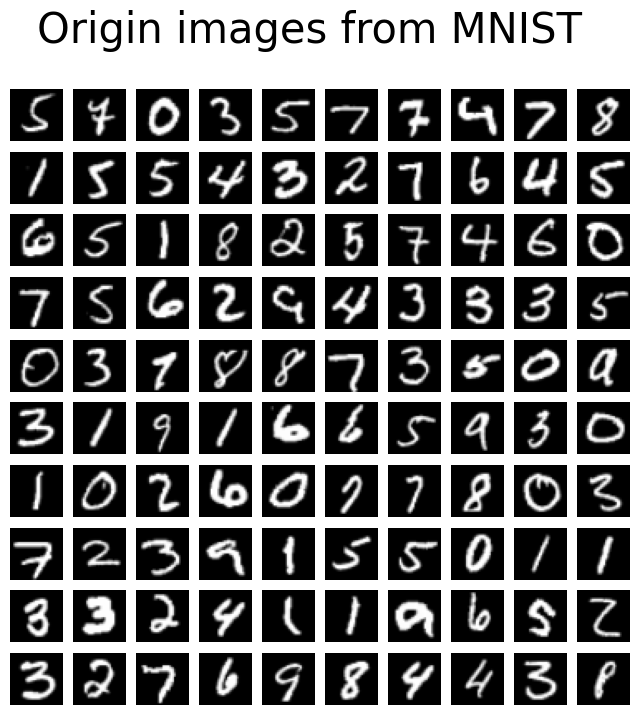

In [ ]:
for b in dataloader:
    batch = b[0]
    break

# select random images from the batch 
bn = [batch[i] for i in np.random.randint(0, batch.shape[0], 100)]
show_images(bn, "Origin images from MNIST") 

### Traininig the model

### 开始训练并保存断点

In [53]:
learning_rate = 1e-3
start_epochs = 0
num_epochs = 60
num_timesteps = 1000
network = TinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
losses = training_loop(model, dataloader, optimizer, start_epochs, num_epochs, num_timesteps, device=device)


Epoch 1:  73%|███████▎  | 11/15 [00:28<00:10,  2.61s/it, loss=0.644]


KeyboardInterrupt: ignored

In [52]:
# 加载模型
checkpoint = torch.load('/content/drive/MyDrive/Models/DDPM/checkpoint/model_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# 继续训练
losses = training_loop(model, dataloader, optimizer, epoch, num_epochs, num_timesteps, device=device)

Epoch 5:   0%|          | 0/15 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

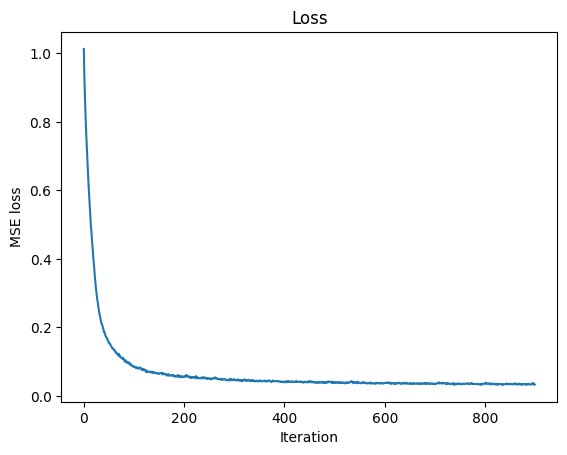

In [ ]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.show()

# 保存模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model, '/content/drive/MyDrive/Models/DDPM/model02.pt')

# 加载模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/Models/DDPM/model.pt"
model = torch.load(model_path)

<ipython-input-39-1c7f4bc6daee>:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


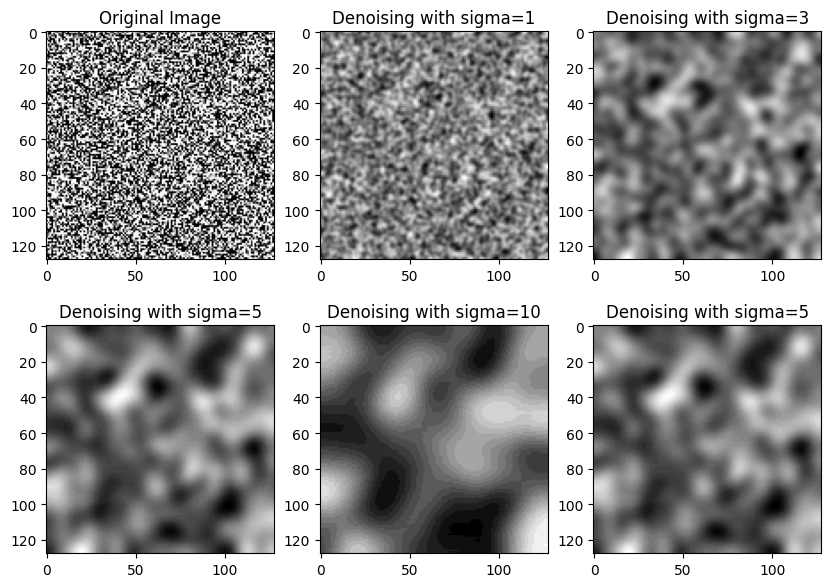

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

def generate_denoising_image(image_size, sigma):
    """
    Generate a noisy image and perform Gaussian filter to denoise it.

    Parameters:
    image_size (int): The size of the image to be generated.
    sigma (float): The standard deviation of Gaussian filter.

    Returns:
    denoising_image (ndarray): The denoised image.
    """

    # Generate a noisy image
    noise = np.random.normal(0, 1, (image_size, image_size))
    image = np.clip((noise + 0.5) * 255, 0, 255).astype(np.uint8)

    # Apply Gaussian filter with the given sigma
    denoising_image = gaussian_filter(image, sigma)

    # Plot the intermediate denoising results
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 1].imshow(gaussian_filter(image, sigma=1), cmap='gray')
    axs[0, 1].set_title('Denoising with sigma=1')
    axs[0, 2].imshow(gaussian_filter(image, sigma=3), cmap='gray')
    axs[0, 2].set_title('Denoising with sigma=3')
    axs[1, 0].imshow(gaussian_filter(image, sigma=5), cmap='gray')
    axs[1, 0].set_title('Denoising with sigma=5')
    axs[1, 1].imshow(gaussian_filter(image, sigma=10), cmap='gray')
    axs[1, 1].set_title('Denoising with sigma=10')
    axs[1, 2].imshow(denoising_image, cmap='gray')
    axs[1, 2].set_title(f'Denoising with sigma={sigma}')
    plt.show()

    return denoising_image
image_size = 128
sigma = 5
denoising_image = generate_denoising_image(image_size, sigma)


### Generating images from the model

100%|██████████| 1000/1000 [00:05<00:00, 191.37it/s]


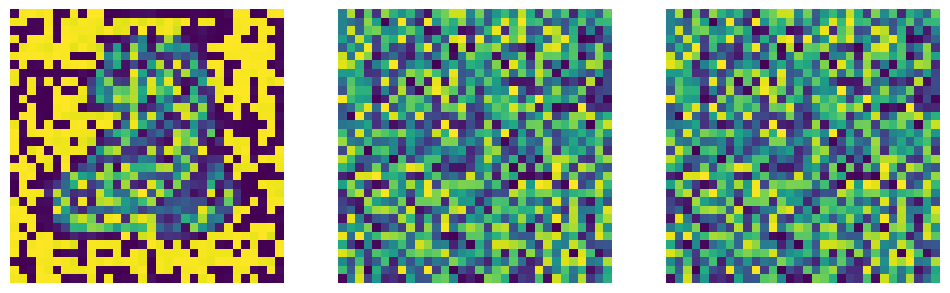

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# from ddpm import DDPM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)

        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t == 500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

# Define a function to generate and display images
def generate_and_display(sample_size, channel, size):
    # Create a diffusion model
    

    # Generate and display images
    frames, frames_mid = generate_image(model, sample_size, channel, size)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        ax[i].axis("off")

    # Plot the generated image
    ax[0].imshow(transforms.ToPILImage()(frames[-1].squeeze(0)))

    # Plot the intermediate denoised images
    ax[1].imshow(transforms.ToPILImage()(frames_mid[0].squeeze(0)))
    ax[2].imshow(transforms.ToPILImage()(frames_mid[-1].squeeze(0)))

    plt.show()

# Generate and display an image
generate_and_display(1, 1, 32)


In [ ]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)

        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t == 500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid


100%|██████████| 1000/1000 [00:07<00:00, 138.08it/s]


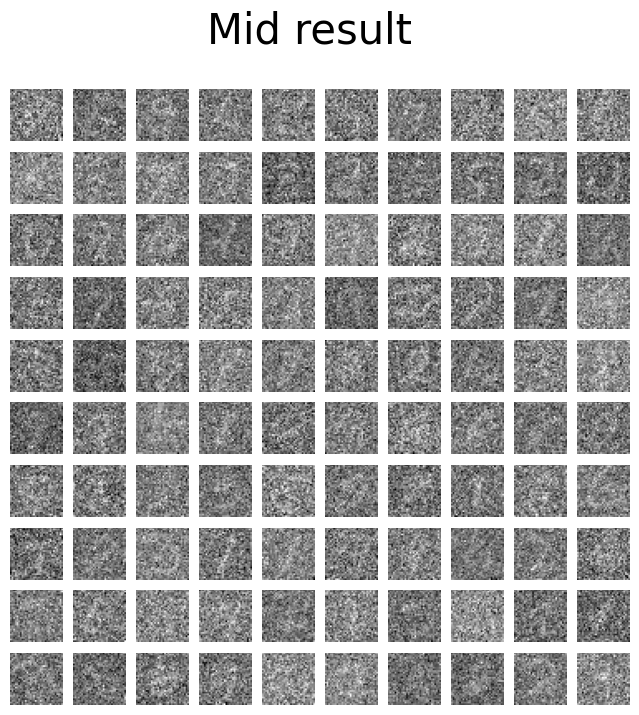

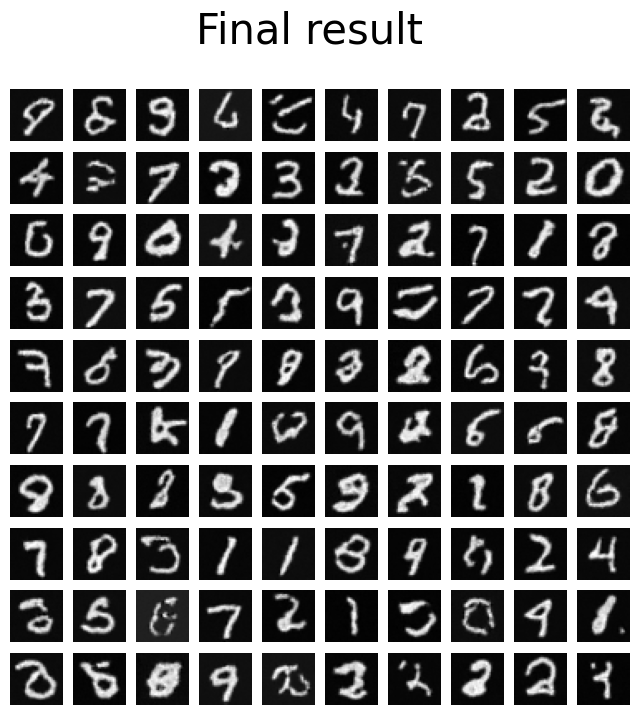

In [ ]:
# generate the image using generate_image
generated, generated_mid = generate_image(model, 100, 1, 32)
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")

#### References

Aakash Nain. 2022. “A Deep Dive into Ddpms.” The Latent (blog). September 2, 2022. https://magic-with-latents.github.io/latent/posts/ddpms/part3/.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.